[0.0, 14.0, 7.0, 3.5, 10.5, 1.91, 12.09, 4.14, 9.86, 0.0, 0.0, 0.0, 0.0, 0.0, -2.3, -2.2978, -4.07, -4.0694]
[0.0, 14.0, 7.0, 3.5, 10.5, 1.91, 12.09, 4.14, 9.86, 0.0, 0.0, 0.0, 0.0, 0.0, -2.3, -2.2978, -4.07, -4.0694]
[7.0, 3.5, 10.5, 1.91, 12.09, 4.14, 9.86, -2.3, -2.2978, -4.07, -4.0694]
[2, 3, 4, 5, 6, 7, 8, 14, 15, 16, 17] [9, 12, 11, 13, 10, 0, 1]
[0.0, 14.0, 7.0, 3.5, 10.5, 1.91, 12.09, 4.14, 9.86, 0.0, 0.0, 0.0, 0.0, 0.0, -2.3, -2.2978, -4.07, -4.0694]


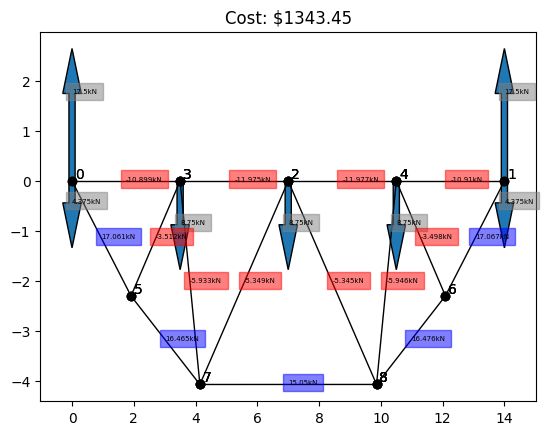

Initial Cost: 1343.45
\begin{bmatrix} (((((((((((((((45+(15*(((((sq((sq(sq((1./(1+pow(2.71828(-10*((((xs_12-xs_11)/sqrt((sq((xs_3-xs_2))+sq((xs_12-xs_11)))))8/((((xs_3-xs_2)/@7)*156)+(157*158))4)4-(((xs_12-xs_11)/sqrt((sq((xs_3-xs_2))+sq((xs_12-xs_11)))))8/((((xs_3-xs_2)/@7)*156)+(157*158))4)5)))))))/(1+pow(2.71828(-10*((((xs_12-xs_11)/sqrt((sq((xs_3-xs_2))+sq((xs_12-xs_11)))))8/((((xs_3-xs_2)/@7)*156)+(157*158))4)4-(((xs_12-xs_11)/sqrt((sq((xs_3-xs_2))+sq((xs_12-xs_11)))))8/((((xs_3-xs_2)/@7)*156)+(157*158))4)5))))))+sq((sq(sq((1./(1+pow(2.71828(-10*((((xs_12-xs_11)/sqrt((sq((xs_3-xs_2))+sq((xs_12-xs_11)))))8/((((xs_3-xs_2)/@7)*156)+(157*158))4)4-(((xs_12-xs_11)/sqrt((sq((xs_3-xs_2))+sq((xs_12-xs_11)))))8/((((xs_3-xs_2)/@7)*156)+(157*158))4)7)))))))/(1+pow(2.71828(-10*((((xs_12-xs_11)/sqrt((sq((xs_3-xs_2))+sq((xs_12-xs_11)))))8/((((xs_3-xs_2)/@7)*156)+(157*158))4)4-(((xs_12-xs_11)/sqrt((sq((xs_3-xs_2))+sq((xs_12-xs_11)))))8/((((xs_3-xs_2)/@7)*156)+(157*158))4)7)))))))+sq((sq(sq((1./(1

In [2]:
from truss_casadi import *
import numpy as np
import scipy as sp
from scipy.optimize import NonlinearConstraint, minimize, Bounds, shgo

truss, bridge_joints, xs = open_file("designs/final/1343.45.json", y_shift=0, flip=False)

unknown_indices = list(np.arange(len(truss.joints)*2))
known_indices = []

for j in bridge_joints:
    # unknown_indices = np.delete(unknown_indices, j+len(truss.joints))
    unknown_indices.remove(j+len(truss.joints))
    known_indices.append(j+len(truss.joints))

# unknown_indices = np.delete(unknown_indices, bridge_joints[0])
unknown_indices.remove(bridge_joints[0])
unknown_indices.remove(bridge_joints[-1])
# unknown_indices = np.delete(unknown_indices, bridge_joints[-1])
known_indices.append(bridge_joints[0])
known_indices.append(bridge_joints[-1])

print(xs)
def correct(X):
    xs_ = xs.copy()
    for i in range(len(unknown_indices)):
        xs_[unknown_indices[i]] = X[i] 
    return xs_

unknowns = []
for i in unknown_indices:
    unknowns.append(xs[i])
print(unknowns)
print(unknown_indices, known_indices)
print(correct(unknowns))

cost = Function('cost', [truss.xs], [truss.cost])
real_cost = Function('real_cost', [truss.xs], [truss.real_cost])
cost_jac_ = Function('cost_jac', [truss.xs], [jacobian(truss.cost, truss.xs)])
[H, g] = hessian(truss.cost, truss.xs)
cost_hess_ = Function('cost_hess', [truss.xs], [H])

cost_jac = lambda x: np.array(cost_jac_(correct(x)))[...,unknown_indices].flatten()
cost_hess = lambda x: np.array(cost_hess_(correct(x)))[unknown_indices, :][:, unknown_indices]

truss.plot(xs, plot_member=True, plot_external=True)

print("Initial Cost:",real_cost(xs))

bridge_links = []
for i, link in enumerate(truss.links):
    if (link.i0 in bridge_joints and link.i1 in bridge_joints) and i not in bridge_links:
        bridge_links.append(i)

print(bridge_links)
print(cost_jac(xs))
print(cost_hess(xs))

In [ ]:
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

nonlinear_constraints = []
for i, link in enumerate(truss.links):
    print(i, link.length)

print(len(truss.links))

for i in range(len(truss.links)):
    upper = np.inf
    if(i in bridge_links):
        upper = 3.5
    nonlinear_constraints.append(NonlinearConstraint(lambda x, i=i: float(Function('length{0}'.format(i),[truss.xs],[truss.links[i].length])(correct(x))), 1, upper))
    nonlinear_constraints.append(NonlinearConstraint(lambda x, i=i: float(Function('length{0}'.format(i),[truss.xs],[truss.links[i].force])(correct(x))), -6*3, 9*3))
for i in range(len(truss.joints)):
    if(truss.joints[i].type == JointType.PIN):
            nonlinear_constraints.append(NonlinearConstraint(lambda x, i=i: float(correct(x)[i]), 0, 0))
    if(truss.joints[i].type == JointType.ROLLER):
            nonlinear_constraints.append(NonlinearConstraint(lambda x, i=i: float(correct(x)[i]), 14, 14))

lower = [-14] * len(unknowns)
upper = [14] * len(unknowns)


bounds = tuple(zip(lower, upper))
print(xs)
print(bounds)

print(nonlinear_constraints)

res = minimize(lambda x: real_cost(correct(x)), unknowns, jac=cost_jac, hess=cost_hess, bounds=bounds, method='trust-constr',options={'initial_constr_penalty':1, 'maxiter':1000, 'verbose': 1}, constraints=[*nonlinear_constraints])

0 sqrt((sq((xs_0-xs_3))+sq((xs_9-xs_12))))
1 sqrt((sq((xs_3-xs_2))+sq((xs_12-xs_11))))
2 sqrt((sq((xs_2-xs_4))+sq((xs_11-xs_13))))
3 sqrt((sq((xs_4-xs_1))+sq((xs_13-xs_10))))
4 sqrt((sq((xs_0-xs_5))+sq((xs_9-xs_14))))
5 sqrt((sq((xs_5-xs_6))+sq((xs_14-xs_15))))
6 sqrt((sq((xs_6-xs_7))+sq((xs_15-xs_16))))
7 sqrt((sq((xs_7-xs_8))+sq((xs_16-xs_17))))
8 sqrt((sq((xs_8-xs_1))+sq((xs_17-xs_10))))
9 sqrt((sq((xs_4-xs_8))+sq((xs_13-xs_17))))
10 sqrt((sq((xs_7-xs_4))+sq((xs_16-xs_13))))
11 sqrt((sq((xs_7-xs_2))+sq((xs_16-xs_11))))
12 sqrt((sq((xs_6-xs_2))+sq((xs_15-xs_11))))
13 sqrt((sq((xs_6-xs_3))+sq((xs_15-xs_12))))
14 sqrt((sq((xs_5-xs_3))+sq((xs_14-xs_12))))
15
[0.0, 14.0, 7.0, 3.4999999999999996, 10.5, 2.0, 5.25, 8.75, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.25, -3.0, -3.0, -2.25]
((-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14))
[<scipy.optimize._constraints.NonlinearConstraint object at 0x7f5751ab3040>, <scipy.optimize._c

           message: The maximum number of function evaluations is exceeded.
           success: False
            status: 0
               fun: 1474.5945354025723
                 x: [ 7.034e+00  3.524e+00  1.053e+01  2.102e+00  6.005e+00
                      8.143e+00  1.194e+01 -2.315e+00 -3.232e+00 -3.202e+00
                     -2.286e+00]
               nit: 1000
              nfev: 1000
              njev: 552
              nhev: 552
          cg_niter: 1163
      cg_stop_cond: 2
              grad: [-3.524e-01 -4.510e+00  4.065e+00  7.693e-02 -9.711e+00
                      1.022e+01 -1.560e-01 -8.061e-02 -2.730e+01 -2.618e+01
                      1.658e-01]
   lagrangian_grad: [ 2.171e-01  8.527e-02  3.378e-01  1.377e-01 -1.236e+00
                      1.593e+00 -4.648e-02  4.112e-01 -2.792e-01  4.549e-01
                      1.094e-01]
            constr: [array([ 3.524e+00]), array([-1.189e+01]), array([ 3.511e+00]), array([-1.758e+01]), array([ 3.498e+00]), array([-1.7

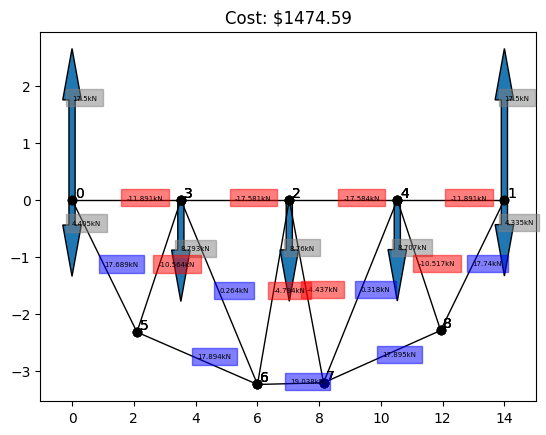

1474.59


In [ ]:
x = correct(res.x)
print(res)
for link in truss.links:
    print(float(Function('length',[truss.xs],[link.length])(x)))

print(x)
truss.plot(x, plot_member=True, plot_external=True)

print(real_cost(x))